<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture

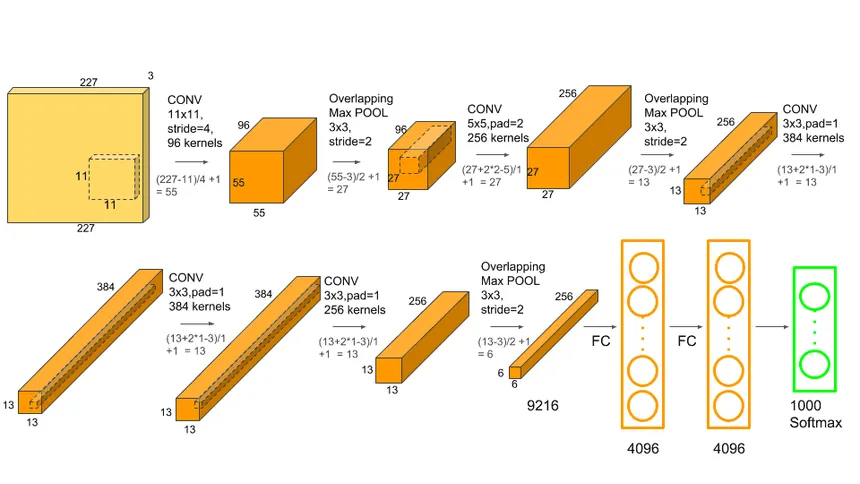

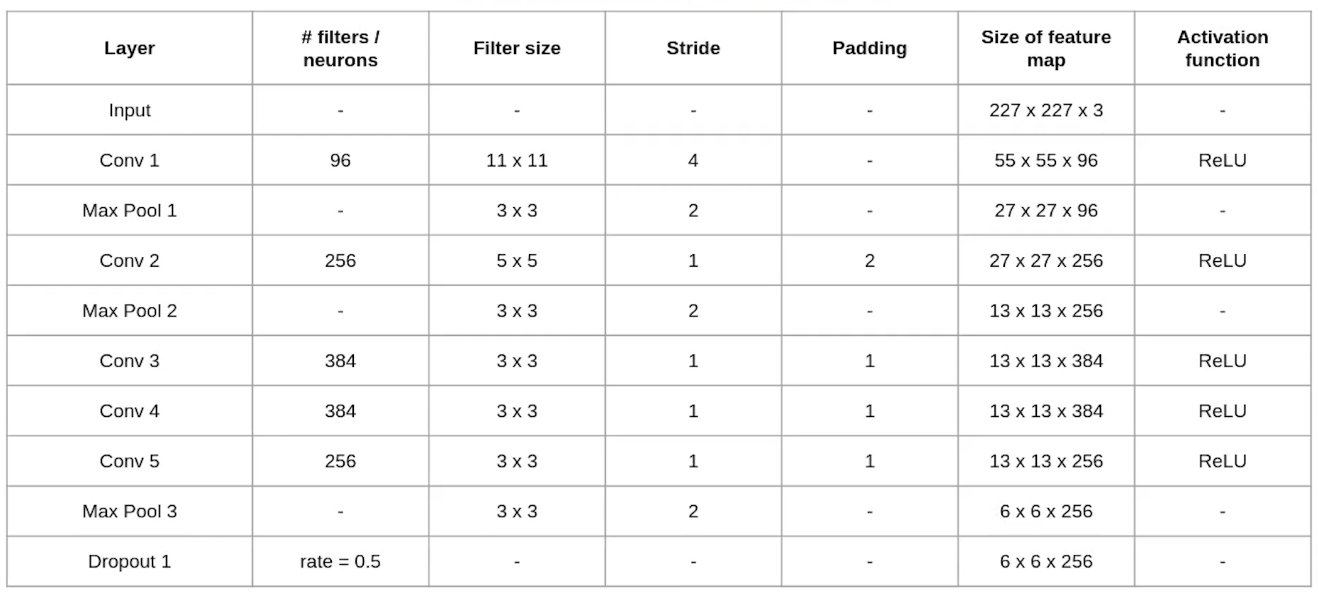

# Code

In [1]:
from google.colab import drive
import os
import shutil
import json
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchsummary import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip

import matplotlib.pyplot as plt
import numpy as np

In [2]:
d_or_c_option = "d"
d_or_c_name = "shaunthesheep/microsoft-catsvsdogs-dataset"

os.system("pip install kaggle")

kaggle_key_path = "/content/drive/MyDrive/Kaggle API Key/kaggle.json"
kaggle_key_dest = "/.kaggle"
dataset_path = "/content/data/"

if os.path.exists(dataset_path) is False:
  if d_or_c_option:
    d_or_c = d_or_c_option
  else:
    d_or_c = str.lower(input("Enter D for dataset or C for competition: "))
  if (d_or_c == 'd'):
    if d_or_c_name:
      d_name = d_or_c_name
    else:
      d_name = input("Enter the name of dataset in 'owner/dataset' format: ")
  elif (d_or_c == 'c'):
    if d_or_c_name:
      c_name = d_or_c_name
    else:
      c_name = input("Enter the name of competition in 'owner/competition' format: ")
  else:
    print("Enter valid option!")

if os.path.exists("/content/drive") is False:
  drive.mount('/content/drive')
  print("Drive is ready to use!")
else:
  print("Drive is already ready to use!")

if os.path.exists(os.path.join(kaggle_key_dest, "kaggle.json")) is False:
  os.mkdir(kaggle_key_dest)
  shutil.copy(kaggle_key_path, kaggle_key_dest)
  os.chmod(os.path.join(kaggle_key_dest, "kaggle.json"), 600)
  print("Kaggle api key is ready to use!")
else:
  print("Kaggle api key is already ready to use!")

if os.path.exists(dataset_path) is False:
  with open(os.path.join(kaggle_key_dest, "kaggle.json"), "r") as f:
    data = json.load(f)
  os.environ["KAGGLE_USERNAME"] = data["username"]
  os.environ["KAGGLE_KEY"] = data["key"]
  del data

  import kaggle

  kaggle.api.authenticate()
  if (d_or_c == 'd'):
    kaggle.api.dataset_download_files(
      d_name,
      path=dataset_path,
      unzip=True
    )
    print("Data was downloaded!")
  elif (d_or_c == 'c'):
    kaggle.api.competition_download_files(
        c_name,
        path=dataset_path
    )
    print("Data was downloaded!")
  else:
    print("No data were downloaded!")
else:
  print("Data is already available!")

Mounted at /content/drive
Drive is ready to use!
Kaggle api key is ready to use!
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
Data was downloaded!


In [3]:
len(os.listdir("/content/data/PetImages/Dog"))

12501

In [4]:
len(os.listdir("/content/data/PetImages/Cat"))

12501

In [5]:
BATCH_SIZE = 32
N_EPOCHS = 100

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
dataset_path = "/content/data/PetImages"

In [8]:
class ValidImgChooser:
    def __init__(self) -> None:
       self.extensions = ["jpg", "png"]
    def __call__(self, path):
        try:
            im = Image.open(path)
            rgb_im = im.convert('RGB')
            if path.split('.')[-1] not in self.extensions:
                return False
        except Exception as e:
            return False
        return True

In [9]:
image_transforms = Compose([
    ToTensor(),
    Resize((227, 227)),  # Alexnet takes input images of shape (3, 227, 227)
    # RandomHorizontalFlip()
])

full_data = ImageFolder(
    root=dataset_path,
    transform=image_transforms,
    is_valid_file=ValidImgChooser()
)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [10]:
label_name = {
    0: "cat",
    1: "dog"
}

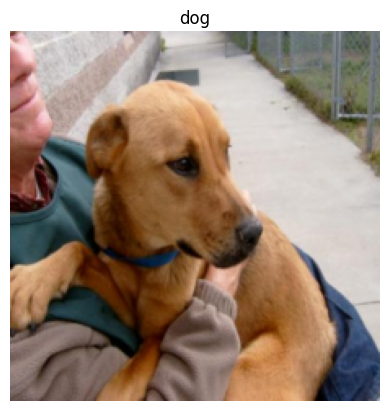

In [11]:
img, label = full_data[np.random.randint(0, len(full_data))]
img = img.detach().cpu()
img = img.permute(1, 2, 0).numpy()
plt.imshow((img * 255).astype(np.uint8))
plt.title(label_name[label])
plt.axis(False)
plt.show()

In [12]:
train, val, test = random_split(full_data, lengths=[17498, 3750, 3750])
print(len(train), len(val), len(test))

17498 3750 3750


In [30]:
train_dl = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dl = DataLoader(
    val,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_dl = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(len(train_dl), len(val_dl), len(test_dl))

TypeError: object of type 'function' has no len()

In [53]:
class AlexNetModel(nn.Module):
    def __init__(self, n_outputs=1, dropout_rate=0.4):
        super(AlexNetModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=96,
            kernel_size=(11, 11),
            stride=4
        )
        self.maxpool1 = nn.MaxPool2d(
            kernel_size=(3, 3),
            stride=(2, 2)
        )
        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=256,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=2
        )
        self.maxpool2 = nn.MaxPool2d(
            kernel_size=(3, 3),
            stride=(2, 2)
        )
        self.conv3 = nn.Conv2d(
            in_channels=256,
            out_channels=384,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=1
        )
        self.conv4 = nn.Conv2d(
            in_channels=384,
            out_channels=384,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=1
        )
        self.conv5 = nn.Conv2d(
            in_channels=384,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=1
        )
        self.maxpool3 = nn.MaxPool2d(
            kernel_size=(3, 3),
            stride=(2, 2)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.dense1 = nn.Linear(
            in_features=6*6*256,
            out_features=512
        )
        self.dense2 = nn.Linear(
            in_features=512,
            out_features=512
        )
        self.dense3 = nn.Linear(
            in_features=512,
            out_features=n_outputs
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = F.relu(self.dense2(x))
        x = self.dropout(x)
        x = self.dense3(x)
        return x

In [54]:
model = AlexNetModel(dropout_rate=0).to(device)
model

AlexNetModel(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0, inplace=False)
  (dense1): Linear(in_features=9216, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=1, bias=True)
)

In [55]:
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         MaxPool2d-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
         MaxPool2d-4          [-1, 256, 13, 13]               0
            Conv2d-5          [-1, 384, 13, 13]         885,120
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
            Conv2d-7          [-1, 256, 13, 13]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
           Dropout-9            [-1, 256, 6, 6]               0
          Flatten-10                 [-1, 9216]               0
           Linear-11                  [-1, 512]       4,719,104
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 512]         262,656
          Dropout-14                  [

In [56]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

In [57]:
def train(model, dataloader, loss_fn, optimizer):
    ds_len = len(dataloader.dataset)
    model.train()
    cum_loss = 0
    for batch, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device).float()
        logits = model(images).squeeze()
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        if batch % 25 == 0:
            current = (batch + 1) * len(labels)
            print(f"\t[{current}/{ds_len}] Loss: {loss.item():.4f}")
    print(f"\t[{ds_len}/{ds_len}] Loss: {loss.item():.4f}")


In [58]:
def test(model, loader, loss_fn):
    model.eval()
    ds_len = len(loader.dataset)
    n_correct = 0
    cum_loss = 0
    print("Testing ...")
    with torch.inference_mode():
        for batch_no, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.float().to(device)
            logits = model(images).squeeze()
            loss = loss_fn(logits, labels)
            cum_loss += loss.item()
            pred = torch.round(torch.sigmoid(logits))
            n_correct += (pred == labels).type(torch.float).sum().item()
        avg_loss = (cum_loss/ds_len)
    print(f"\t[{ds_len}/{ds_len}] Loss: {avg_loss:.3f} | Accuracy: {(n_correct/ds_len)*100:.3f}%")
    return avg_loss

In [59]:
prev_loss = 9999999
saved_weight = None
for i in range(1, N_EPOCHS+1):
    print(f"EPOCH {i} Training...")
    train(model, train_dl, loss_fn, optimizer)
    current_loss = test(model, val_dl, loss_fn)
    if current_loss >= prev_loss:
        print("Training ended")
        break
    prev_loss = current_loss
    saved_weight = model.state_dict()
model.load_state_dict(saved_weight)

EPOCH 1 Training...
	[32/17498] Loss: 0.6926
	[832/17498] Loss: 0.6932
	[1632/17498] Loss: 0.6927
	[2432/17498] Loss: 0.6839
	[3232/17498] Loss: 0.7003
	[4032/17498] Loss: 0.6883
	[4832/17498] Loss: 0.6915
	[5632/17498] Loss: 0.6899
	[6432/17498] Loss: 0.6933
	[7232/17498] Loss: 0.6914
	[8032/17498] Loss: 0.6921
	[8832/17498] Loss: 0.6945
	[9632/17498] Loss: 0.6960
	[10432/17498] Loss: 0.6938


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


	[11232/17498] Loss: 0.6947
	[12032/17498] Loss: 0.6928
	[12832/17498] Loss: 0.6911
	[13632/17498] Loss: 0.6673
	[14432/17498] Loss: 0.6903
	[15232/17498] Loss: 0.6887
	[16032/17498] Loss: 0.6835
	[16832/17498] Loss: 0.7185
	[17498/17498] Loss: 0.6964
Testing ...
	[3750/3750] Loss: 0.021 | Accuracy: 53.840%
EPOCH 2 Training...
	[32/17498] Loss: 0.6864
	[832/17498] Loss: 0.7050
	[1632/17498] Loss: 0.6491
	[2432/17498] Loss: 0.6514
	[3232/17498] Loss: 0.7148
	[4032/17498] Loss: 0.6665
	[4832/17498] Loss: 0.6231
	[5632/17498] Loss: 0.6088
	[6432/17498] Loss: 0.7666
	[7232/17498] Loss: 0.6564
	[8032/17498] Loss: 0.5744
	[8832/17498] Loss: 0.5489
	[9632/17498] Loss: 0.7781
	[10432/17498] Loss: 0.7508
	[11232/17498] Loss: 0.6234
	[12032/17498] Loss: 0.6338
	[12832/17498] Loss: 0.5567
	[13632/17498] Loss: 0.7536
	[14432/17498] Loss: 0.6812
	[15232/17498] Loss: 0.4877
	[16032/17498] Loss: 0.5209
	[16832/17498] Loss: 0.7178
	[17498/17498] Loss: 0.5969
Testing ...
	[3750/3750] Loss: 0.019 | Accu

<All keys matched successfully>

In [60]:
test(model, train_dl, loss_fn)

Testing ...
	[17498/17498] Loss: 0.005 | Accuracy: 93.559%


0.004918593958344667

In [61]:
test(model, val_dl, loss_fn)

Testing ...
	[3750/3750] Loss: 0.010 | Accuracy: 87.653%


0.009821401397387186

In [62]:
test(model, test_dl, loss_fn)

Testing ...
	[3750/3750] Loss: 0.009 | Accuracy: 88.080%


0.009242170510689417

In [63]:
torch.save(model, "/content/model.pth")

torch.Size([3, 227, 227])
1


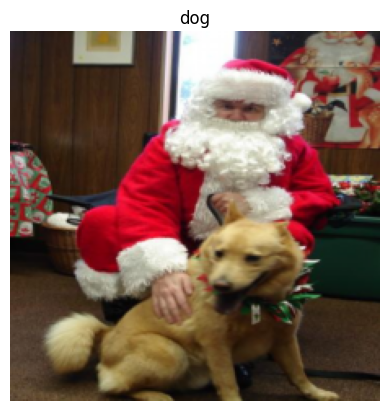

In [69]:
img, label = full_data[np.random.randint(0, len(full_data))]
print(img.shape)
pred = torch.round(torch.sigmoid(model(img.unsqueeze(0).to(device)).squeeze())).int().item()
print(pred)
img = img.detach().cpu()
img = img.permute(1, 2, 0).numpy()
plt.imshow((img * 255).astype(np.uint8))
plt.title(label_name[label])
plt.axis(False)
plt.show()

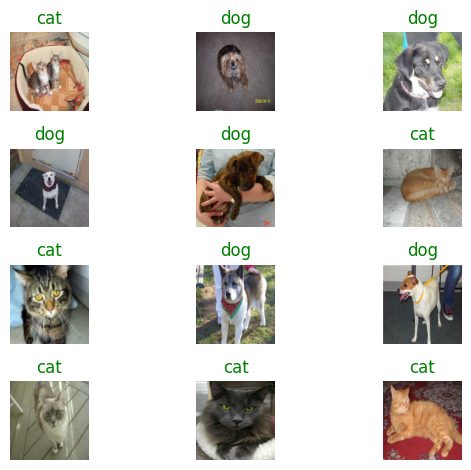

In [74]:
n_rows = 4
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols)
for i in range(n_rows):
    for j in range(n_cols):
        img, label = full_data[np.random.randint(0, len(full_data))]
        pred = torch.round(torch.sigmoid(model(img.unsqueeze(0).to(device)).squeeze())).int().item()
        y_pred_label = label_name[pred]
        img = img.detach().cpu()
        img = img.permute(1, 2, 0).numpy()
        axs[i][j].imshow((img * 255).astype(np.uint8))
        if label == pred:
            axs[i][j].set_title(y_pred_label, c="g")
        else:
            axs[i][j].set_title(y_pred_label, c="r")
        axs[i][j].axis(False)
fig.tight_layout()
plt.show()